In [1]:
print('hello world')

hello world


https://github.com/Varun-Date98/pytorch-vision-transformer/blob/main/vision-transformer.ipynb

In [6]:
import os
import random
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd

import torch
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from classes.ViT import PatchEmbeddings, MultiHeadSelfAttentionBlock, MLPLayer, TransformerEncoderBlock, ViT
from classes.RetinaDataset import RetinaDataset
from tools.data_tools import crop_image_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Preparing data for training

In [9]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


In [10]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

In [11]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='binary'
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

In [6]:
# Checking that dataloader is working as expected
samples, labels = next(iter(train_dataloader))
print("Train dataloader length", len(train_dataloader))
print(f"Samples shape: {samples.shape} | Labels shape: {labels.shape}")

Train dataloader length 30
Samples shape: torch.Size([64, 3, 256, 256]) | Labels shape: torch.Size([64, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4838063..3.4092274].


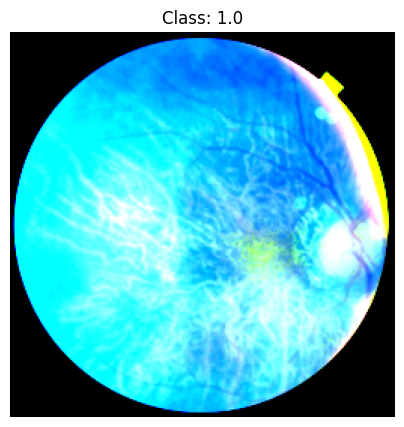

In [7]:
# Plotting a random image from samples
idx = random.randint(0, 63)
img, lbl = samples[idx], labels[idx]

plt.figure(figsize=(5, 5))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {lbl.item()}")
plt.axis(False)
plt.show()

## 2. Re-creating the Vision Transformer Model

There are _ core parts of a Vision Transformer

1. Patch Embeddings - Converts the input image into fixed size patches, flattens them and projects them into an embedding space. Also, adds a learnable class token and position embeddings to retain spatial data.
2. Multi Headed Self Attention - Learns relationships between different patches of the image allowing the model to learn wider dependencies in the image.
3. Multi Layer Perceptron - This is a feed forward layer that expands feature dimensions and adds non-linearity to the network using GELU activation.
4. Transformer Encoder Block - Uses Multi-Headed Self Attention (MHSA) and Multi Layer Perceptron (MLP) with Residual connections to create a holistic understanding of the image.
I will use the default sizes from the ViT paper to create this model. That means the image dimensions will be 224 x 224, patch size is 16 and embeddings dimension is 768.

### 2.1 Creating Patch Embeddings layer

The PatchEmbeddings layer of the Vision Transformer converts the input image into fixed size blocks. These blocks are then flattened into a single dimension. It also creates a learnable ClassToken and PositionEmbeddings, the class token is prepended to the flattened feature maps and then the position embeddings are added.

We will follow the below steps to recreate this layer:

1. Convert the image to patches using torch.nn.Conv2d.
2. Flatten the image patches into a single dimension tensor using torch.nn.Flatten.
3. Create a learnable Class Token using nn.Parameter.
4. Create a learnable Position Embedding using nn.Parameter
5. Prepend the Class Token to the flattened feature maps.
6. Add Position Embeddings to the flattened feature maps.

In [8]:
# Testing the PatchEmbeddings class

patchefier = PatchEmbeddings()
image = torch.randn(3, 64, 64).unsqueeze(0)    # Adding batch dimension
print(f"Input dimensions: {image.shape}")
patch_pos_embedding_out = patchefier(image)
print(f"Patch Embedding dimensions: {patch_pos_embedding_out.shape}")

Input dimensions: torch.Size([1, 3, 64, 64])
Patch Embedding dimensions: torch.Size([1, 257, 256])


### 2.2 Creating Multi-Headded Self-Attention block

To create the MHSA block we will use some prebuilt layers available in PyTorch.

- Multi-Headed Self-Attention (MHSA) - torch.nn.MultiheadAttention
- Layer Norm (LN) - torch.nn.LayerNorm
- Residual connection - add the input from previous layer to its output

**Layer Norm:**

A LayerNorm standardizes the input tensor to have similar mean and standard deviation. This helps neural networks to optimize data and improve efficiency.

**Multi-Headed Self-Attention:**

The original Transformer architecture relies on the power of self-attention or multi-head attention (self-attention applied multiple times).

Originally designed for text input, the self-attention mechanism takes a sequence of words and then calculates which word should pay more attention to another word.

Since our input is a sequence of image patches rather than words, self-attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of the image.

The implementation of multi-head attention takes three inputs query, key and value. In our case, this input will be three versions of the output of the Norm layer, one for query, key and value.

To do so we will:

1. Create a class called MultiHeadSelfAttentionBlock.
2. Initialize the class with hyper-parameters from ViT paper for the base ViT model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm with the normalized_shape parameter the same as our embedding embedding dimension.
4. Create a multi-head self attention (MHSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create the forward method for our class passing the inputs through the LN and MHSA layers.

In [9]:
# Testing MHSA block
multi_head_sa_block = MultiHeadSelfAttentionBlock(embedding_dim=256, num_heads=8)
mhsa_out = multi_head_sa_block(patch_pos_embedding_out)
print(f"Tensor shape before MHSA block: {patch_pos_embedding_out.shape}")
print(f"Tensor shape after MHSA block: {mhsa_out.shape}")

Tensor shape before MHSA block: torch.Size([1, 257, 256])
Tensor shape after MHSA block: torch.Size([1, 257, 256])


### 2.3 Creating the Multilayer Perceptron block

Let us now create the last part of the Vision Transformer, the Transformer Encoder Block. This block uses a Multi Layer Perceptron (MLP) layer and the Multi-Headed Self-Attention (MHSA) layers to produce the final output. It achieves this by passing the outputs of MHSA layer through an MLP layer which is just a dense layer that outputs the image class.

We will implement the following to complete our Transformer Encoder Block:

1. Replicate the MLPLayer from ViT paper with parameters for the base ViT model.
2. Create a TransformerEncoderBlock class to combine MultiHeadSelfAttentionBlock and MLPLayer.

In [10]:
# Testing the MLP block
mlp_block = MLPLayer(embedding_dim=256, mlp_size=1024, dropout=0.1)
mlp_out = mlp_block(mhsa_out)
print(f"Tensor shape before MLP block: {mhsa_out.shape}")
print(f"Tensor shape after MLP block: {mlp_out.shape}")

Tensor shape before MLP block: torch.Size([1, 257, 256])
Tensor shape after MLP block: torch.Size([1, 257, 256])


In [11]:
# Testing the Transformer encoder block
transformer_encoder_block = TransformerEncoderBlock()
transormer_encoder_out = transformer_encoder_block(patch_pos_embedding_out)
print(f"Tensor shape before Transformer Encoder block: {patch_pos_embedding_out.shape}")
print(f"Tensor shape after Transformer Encoder block: {transormer_encoder_out.shape}")

Tensor shape before Transformer Encoder block: torch.Size([1, 257, 256])
Tensor shape after Transformer Encoder block: torch.Size([1, 257, 256])


## Putting it all together to create ViT

Now that we have replicated all parts of the ViT model separately, its time to put them together and create the full ViT model.

To do this we will:

1. Create a class ViT that inherits from torch.nn.Module.
2. Initialize the class with hyper-parameters from the ViT paper for the base model.
3. Setup the embedding dropout layer.
4. Create the patch embedding layer using the PatchEmbedding class.
5. Create a series of Transformer Encoder Blocks by passing a list of TransformerEncoderBlocks to torch.nn.Sequential().
6. Create a classifier head using nn.LayerNorm() and nn.Linear() and passing them through nn.Sequential()
7. Create a forward() method that accepts an input.
8. Get patch and position embeddings from the PatchEmbeddings layer.
9. Pass the patch and position embedding through the dropout layer created in step 3.
10. Pass the patch and position embedding from step 9 through the stack of Transformer Encoder layers.
11. Pass index 0 of the output of the stack of Transformer Encoder layers from previous step through the classifier head created.
12. And we are done with the full Vision Transformer model.

In [12]:
# Testing out the ViT model on one random batch

model = ViT(num_classes=1)
random_image_tensor = torch.randn(64, 3, 64, 64)
vit_out = model(random_image_tensor)
print(f"Shape of the input of ViT model: {random_image_tensor.shape}")
print(f"Shape of the final output of ViT model: {vit_out.shape}")

Shape of the input of ViT model: torch.Size([64, 3, 64, 64])
Shape of the final output of ViT model: torch.Size([64, 1])


In [13]:
# Checking size of our model using torchinfo

summary(model=model,
        input_size=(64, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [64, 3, 64, 64]      [64, 1]              --                   True
├─PatchEmbeddings (patch_embed_layer)              [64, 3, 64, 64]      [64, 257, 256]       66,048               True
│    └─Conv2d (patcher)                            [64, 3, 64, 64]      [64, 256, 16, 16]    12,544               True
│    └─Flatten (flatten)                           [64, 256, 16, 16]    [64, 256, 256]       --                   --
├─Dropout (embedding_dropout)                      [64, 257, 256]       [64, 257, 256]       --                   --
├─Sequential (tfm_enc_blocks)                      [64, 257, 256]       [64, 257, 256]       --                   True
│    └─TransformerEncoderBlock (0)                 [64, 257, 256]       [64, 257, 256]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa)  

Now that's a massive model with over 85 million trainable parameters. Training the model will be a massive task. Due to the limited hardware, we will reduce the number of transformer layers if it takes too long to train the model.

Finally we have replicated all the core layers of the Vision Transformer model and passed a random image through the model. The model outputs a tensor of length 200 for each image in the batch. Each element of the tensor correspond to the probability of the image belonging to that class. We can extract the class index from this tensor using torch.argmax() function and then get the name of the class using index_to_class dictionary.

## 3. Training the model

Now that we have succesfully recreated the ViT model, we are all set to train it on our tiny-imagenet-200 dataset. We have already created the train_dataloader and the test_dataloader. Now we just need to set-up the training and testing loops. We will modularize this part as well and create separate, reusable functions for training loop and testing loop. We will also leverage GPUs to accelerate training of the model. We will also use torch.amp.GradScaler() to speed up training process.

In [14]:
# Setting up device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device.type}")

Training on device: cuda


In [15]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.cuda.amp.GradScaler,
               device: torch.device = device):
    # Putting the model in training mode
    model.train()

    # Creating metrics that will be tracked throughout the step
    train_loss, train_acc, total_samples = 0, 0, 0

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Training")):
        # Sending X and y to the target device
        X, y = X.to(device), y.to(device)

        # Making prediction and calculating loss
        with torch.amp.autocast("cuda", enabled=device.type == "cuda"):
            preds = model(X)
            loss = loss_fn(preds, y.squeeze().long())
        
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward and optimizer step
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Calculating accuracy
        pred_classes = torch.argmax(preds, dim=1)
        train_acc += (pred_classes == y.squeeze().long()).sum().item()
        total_samples += y.size(0)

    # Adjusting training loss and accuracy per batch
    train_loss /= total_samples
    train_acc /= total_samples
    return train_loss, train_acc

In [16]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    # Putting the model in evaluation mode
    model.eval()

    # Creating metrics that will be tracked throughout the step
    test_loss, test_acc, total_samples = 0, 0, 0

    with torch.inference_mode():
        with torch.amp.autocast("cuda", enabled=device.type == "cuda"):
            for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Evaluating")):
                # Sending X and y to target device
                X, y = X.to(device), y.to(device)

                # Making predictions
                test_pred_logits = model(X)

                # Calculating loss
                loss = loss_fn(test_pred_logits, y.squeeze().long())
                test_loss += loss.item()

                # Calculating test accuracy
                test_pred_labels = test_pred_logits.argmax(dim=1)
                test_acc += (test_pred_labels == y.squeeze().long()).sum().item()
                total_samples += y.size(0)

            # Adjusting training loss and accuracy per batch
            test_loss /= total_samples
            test_acc /= total_samples
            return test_loss, test_acc

In [17]:
def train_model(model: torch.nn.Module,
                model_save_path: str,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                scheduler: torch.optim.Optimizer,
                epochs: int = 5,
                device: torch.device = device):
    # Tracking loss and accuracy for both training and testing loops
    results = {
        "train_loss": [0],
        "train_acc": [0],
        "test_loss": [0],
        "test_acc": [0]
    }
    
    best_acc = 0
    pbar = trange(0, epochs, leave=False, desc="Epoch")
    scaler = torch.amp.GradScaler() if device.type == "cuda" else None

    for epoch in pbar:
        pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (results["train_acc"][-1] * 100, results["test_acc"][-1] * 100))
        
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scaler=scaler,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                         dataloader=test_dataloader,
                                         loss_fn=loss_fn,
                                         device=device)

        if scheduler:
            scheduler.step()
        
        if model_save_path not in [None, ""] and test_acc > best_acc:
            torch.save(model.state_dict(), model_save_path)
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [34]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"][1:]
    test_loss = results["test_loss"][1:]

    accuracy = results["train_acc"][1:]
    test_accuracy = results["test_acc"][1:]

    epochs = range(len(results["train_loss"]) - 1)

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="validation_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="validation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylim(0, 1)
    plt.legend()

In [19]:
# Creating a baseline model
baseline_model = ViT(img_size=256, num_classes=2, num_transformer_layers=1).to(device)

# Model optimizer and scheduler
baseline_optimizer = torch.optim.AdamW(params=baseline_model.parameters(), lr=5e-4)
baseline_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(baseline_optimizer,
                                                                   T_max=50,
                                                                   eta_min=1e-5)

# Loss function
baseline_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [20]:
# Overfitting on a small subset

X, y = next(iter(train_dataloader))

X, y = X[:10].to(device), y[:10].to(device)
print(f"Unique labels in y: {torch.unique(y)}")
print(f"All labels: {y.squeeze()}")
print(f"Shape of X: {X.shape} | Shape of y: {y.shape}")
print(f"""Be aware that it may contain only one class, 
which would make it impossible for the model to learn to differentiate between classes.
If that's the case, try again until you get a batch with both classes represented.\n""")

model.train()

for step in range(100):
    baseline_optimizer.zero_grad()
    preds = baseline_model(X)
    loss = baseline_loss_fn(preds, y.squeeze().long()) # Squeeze to from [8, 1] to [8] and convert to long for CrossEntropyLoss
    loss.backward()
    baseline_optimizer.step()

    if step % 10 == 0:
        acc = (preds.argmax(dim=1) == y.squeeze().long()).float().mean()
        print(f"Step {step} | Loss={loss.item():.4f}, Acc={acc.item():.4f}")

Unique labels in y: tensor([0., 1.], device='cuda:0')
All labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], device='cuda:0')
Shape of X: torch.Size([10, 3, 256, 256]) | Shape of y: torch.Size([10, 1])
Be aware that it may contain only one class, 
which would make it impossible for the model to learn to differentiate between classes.
If that's the case, try again until you get a batch with both classes represented.

Step 0 | Loss=1.6675, Acc=0.1000
Step 10 | Loss=0.3896, Acc=0.9000
Step 20 | Loss=0.3898, Acc=0.9000
Step 30 | Loss=0.3901, Acc=0.9000
Step 40 | Loss=0.3100, Acc=0.9000
Step 50 | Loss=0.2573, Acc=1.0000
Step 60 | Loss=0.2506, Acc=1.0000
Step 70 | Loss=0.2706, Acc=0.9000
Step 80 | Loss=0.2128, Acc=1.0000
Step 90 | Loss=0.2015, Acc=1.0000


In [22]:
# Training the baseline model for 50 epochs

baseline_results = train_model(model=baseline_model,
                               train_dataloader=train_dataloader,
                               test_dataloader=val_dataloader,
                               optimizer=baseline_optimizer,
                               loss_fn=baseline_loss_fn,
                               scheduler=baseline_lr_scheduler,
                               model_save_path="../Models/baseline_vit.pth",
                               epochs=50,
                               device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

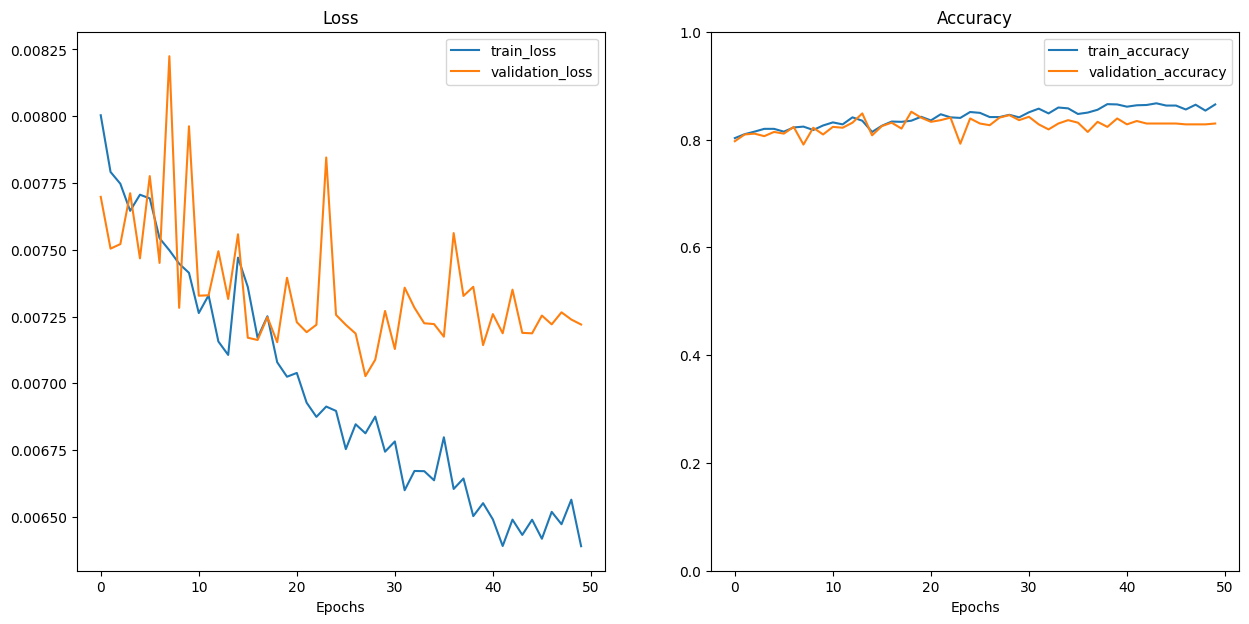

In [35]:
plot_loss_curves(baseline_results)


As we can see our model is learning steadily and the training loss keeps dropping smoothly per epoch. While the accuracy is low, near 20%, this is expected when training a model like the Vision Transformer from scratch is a very difficult task. Vast amounts of data is needed to get any good accuracy on a transformer model. The authors of the original paper pre-trained the model on JFT-300M data set and then fine tuned the model on smaller data sets.

## 4. Predicting on unseen data

Let's now use the unseen test data to predict its classes using our model. We will:

1. Create a new model instance
2. Load the saved baseline_model_weights
3. Use this model to make some predictions on test images

In [3]:
import random

In [7]:
prod_model = ViT(img_size=256, num_classes=2, num_transformer_layers=1)
prod_model.load_state_dict(torch.load("../Models/baseline_vit.pth"))
prod_model.to(device)

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embed_layer): PatchEmbeddings(
    (patcher): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (tfm_enc_blocks): Sequential(
    (0): TransformerEncoderBlock(
      (msa): MultiHeadSelfAttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
      )
      (mlp): MLPLayer(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=1024, out_features=256, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (fcs): Sequential(
    (0): LayerNor

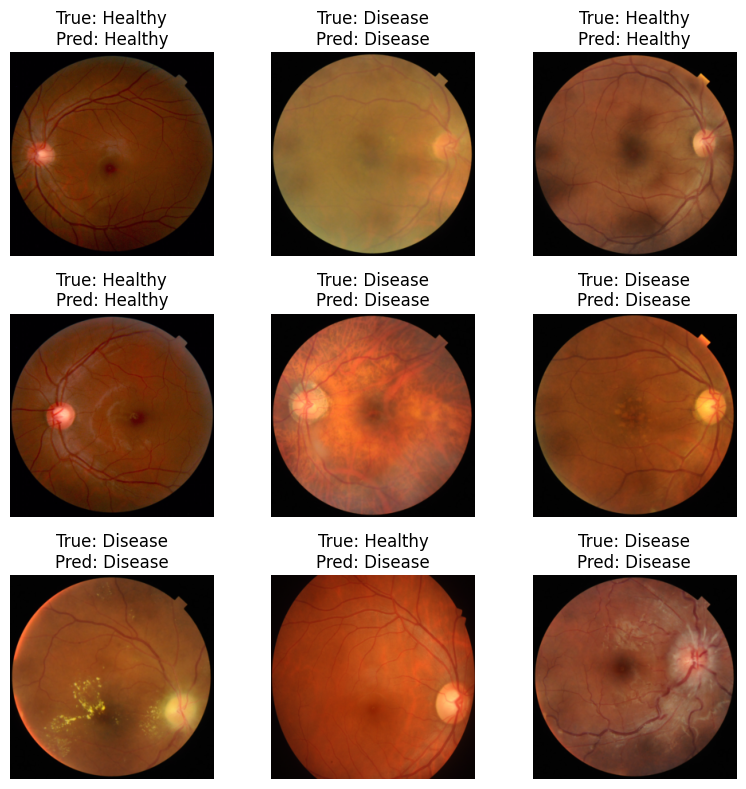

In [21]:
# Modifie load_test_images() pour retourner aussi les labels
def load_test_images():
    indices = random.sample(range(len(test_dataset)), k=9)
    test_batch = []
    true_labels = []
    
    for idx in indices:
        img, label = test_dataset[idx]
        test_batch.append(img)
        true_labels.append(label.item())  # Récupère la valeur numérique du label
    
    return torch.stack(test_batch), true_labels


# Récupère les images et les vrais labels
test_batch, true_labels = load_test_images()

# Fais les prédictions
test_batch_tensor = test_batch.to(device)
prod_model.eval()

with torch.no_grad():
    preds = prod_model(test_batch_tensor)
    pred_classes = torch.argmax(preds, dim=1)


# Modifie la fonction pour afficher les deux
idx_to_class = {0: "Healthy", 1: "Disease"}

def plot_img_predictions(imgs: list, predictions: list, true_labels: list):
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    
    for i, ax in enumerate(ax.flat):
        # Dénormaliser l'image
        img = imgs[i].clone()
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        # Afficher
        ax.imshow(img.permute(1, 2, 0))
        
        # Afficher les deux classes
        pred_class = idx_to_class[predictions[i]]
        true_class = idx_to_class[true_labels[i]]
        ax.set_title(f"True: {true_class}\nPred: {pred_class}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


plot_img_predictions(test_batch, pred_classes.tolist(), true_labels)